In [2]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [18]:
#加载葡萄酒数据集
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
print(df_wine.info)

<bound method DataFrame.info of      0      1     2     3     4    5     6     7     8     9          10  \
0     1  14.23  1.71  2.43  15.6  127  2.80  3.06  0.28  2.29   5.640000   
1     1  13.20  1.78  2.14  11.2  100  2.65  2.76  0.26  1.28   4.380000   
2     1  13.16  2.36  2.67  18.6  101  2.80  3.24  0.30  2.81   5.680000   
3     1  14.37  1.95  2.50  16.8  113  3.85  3.49  0.24  2.18   7.800000   
4     1  13.24  2.59  2.87  21.0  118  2.80  2.69  0.39  1.82   4.320000   
5     1  14.20  1.76  2.45  15.2  112  3.27  3.39  0.34  1.97   6.750000   
6     1  14.39  1.87  2.45  14.6   96  2.50  2.52  0.30  1.98   5.250000   
7     1  14.06  2.15  2.61  17.6  121  2.60  2.51  0.31  1.25   5.050000   
8     1  14.83  1.64  2.17  14.0   97  2.80  2.98  0.29  1.98   5.200000   
9     1  13.86  1.35  2.27  16.0   98  2.98  3.15  0.22  1.85   7.220000   
10    1  14.10  2.16  2.30  18.0  105  2.95  3.32  0.22  2.38   5.750000   
11    1  14.12  1.48  2.32  16.8   95  2.20  2.43  0.26 

In [10]:
from sklearn.preprocessing import StandardScaler
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)


In [11]:
class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size,random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_=[self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train,X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score
    
            
        

In [12]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

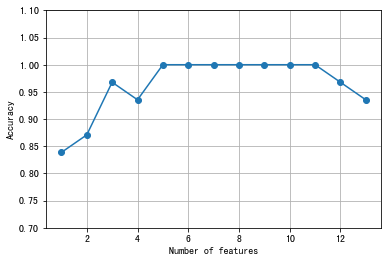

In [13]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [16]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])


Int64Index([1, 2, 4, 11, 13], dtype='int64')


In [17]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))
#此结果暗示模型稍有过拟合

Training accuracy: 0.9838709677419355
Test accuracy: 0.9444444444444444


In [ ]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))